# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


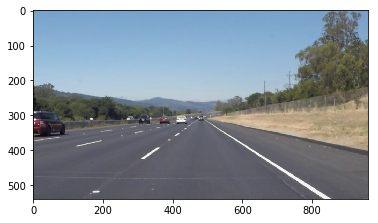

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)
plt.show()# if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            #Filtering slope to avoid noice
            if(slope>=0.2 or  ( slope<=-0.5)):
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg']

run your solution on all test_images and make copies into the test_images directory).

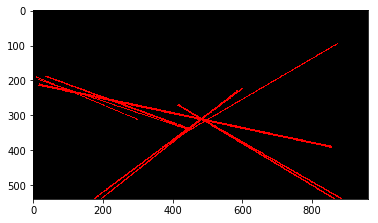

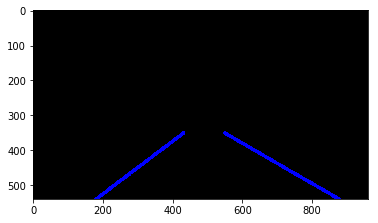

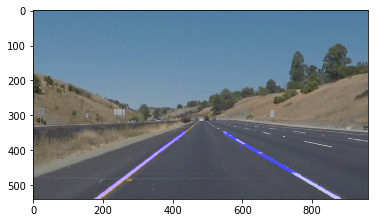

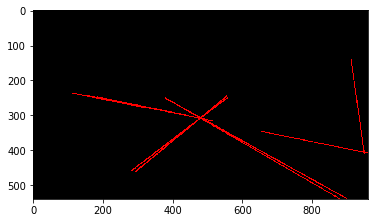

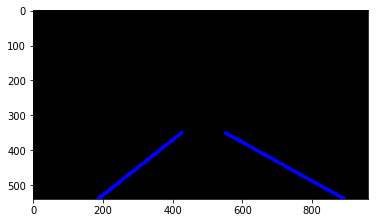

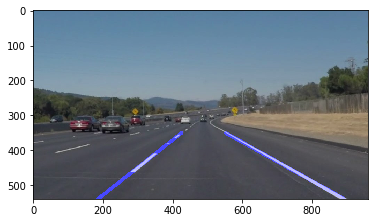

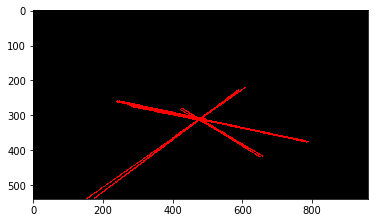

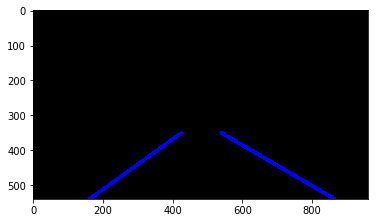

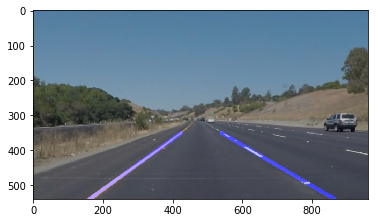

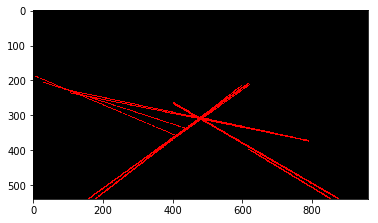

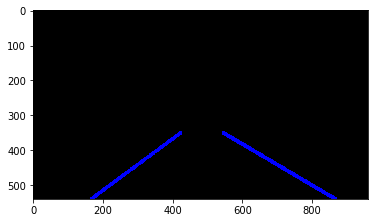

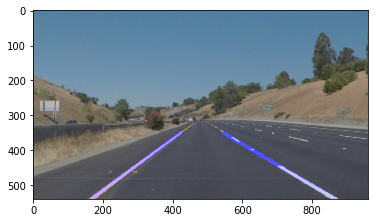

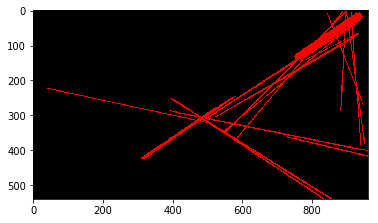

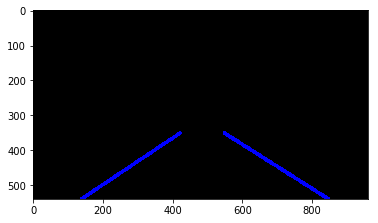

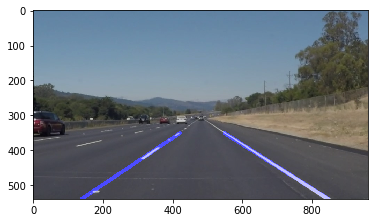

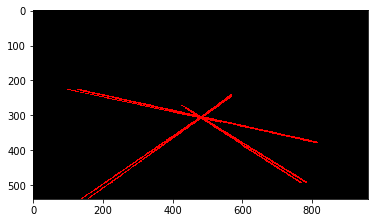

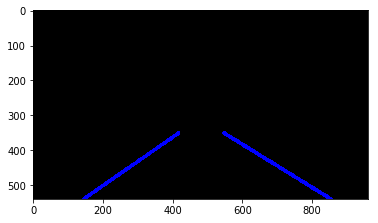

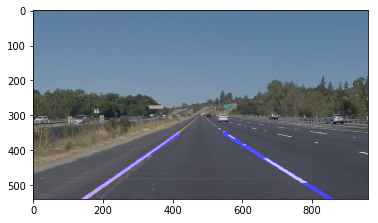

In [4]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
imageNames = os.listdir("test_images/")
for imageName in imageNames:
    img = mpimg.imread('test_images/' + imageName)
    imshape = img.shape
    
    
    #Apply gray scale to selected image 
    grayScaleImg = grayscale(img)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blurredImg = gaussian_blur(grayScaleImg,kernel_size)
    
    #Apply canny
    low_threshold = 50
    high_threshold = 100
    edgeImg = canny(blurredImg,low_threshold,high_threshold)
    #plt.imshow(edgeImg)
    #plt.show()
    
    #Apply hough transform 
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = (np.pi/180)*0.01 # angular resolution in radians of the Hough grid
    threshold = 50    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 160 #minimum number of pixels making up a line
    max_line_gap = 100   # maximum gap in pixels between connectable line segments
    houghImg = hough_lines(edgeImg,rho,theta,threshold,min_line_length,max_line_gap) 
    plt.imshow(houghImg)
    plt.show()
    
    #Vertices for masking 
    vertices = np.array([[(0,imshape[0]),(0.46875*imshape[1], 0.6111*imshape[0]), (0.51041*imshape[1],0.6111*imshape[0] ), (imshape[1],imshape[0])]], dtype=np.int32)
    maskedImg =  region_of_interest(houghImg,vertices)
    
    #Center of image
    centerColumn = int(imshape[1]/2)
     
    leftLineXPts = []
    leftLineYPts = []
    rightLineXPts = []
    rightLineYPts = []
    
    #Collect left points 
    for row in range(imshape[0]):
        for col in range(centerColumn):
            if(maskedImg[row][col][0]!=0):
                leftLineXPts.append(col)
                leftLineYPts.append(row)
                
    
    #Collect right points 
    for row in range(imshape[0]):
        for col in range(centerColumn,imshape[1]):
            if(maskedImg[row][col][0]!=0):
                rightLineXPts.append(col)
                rightLineYPts.append(row)
                
    
    #Fit line to left points 
    leftSlope,leftIntercept = np.polyfit(leftLineXPts,leftLineYPts,1)
    
    #Fit line to right points 
    rightSlope,rightIntercept = np.polyfit(rightLineXPts,rightLineYPts,1)
    
    #fitted left line endpoints
    leftLinePts =  np.array([(0.65*imshape[0] - leftIntercept)/leftSlope, 0.65*imshape[0], (imshape[0] - leftIntercept)/leftSlope, imshape[0] ],dtype=np.int32)
    
    #fitted right line endpoints 
    rightLinePts =  np.array([(0.65*imshape[0] - rightIntercept)/rightSlope, 0.65*imshape[0], (imshape[0] - rightIntercept)/rightSlope, imshape[0] ],dtype=np.int32)
    
    #define left line
    leftLine =  np.array([leftLinePts],dtype=np.int32)
    #define right line 
    rightLine = np.array([rightLinePts],dtype=np.int32)
    
    #draw lines
    lines = np.array([leftLine,rightLine],dtype=np.int32)
    draw_lines(maskedImg,lines,[0, 0, 255],10)
    
    #Remove hough lines 
    red_threshold = 255
    green_threshold = 0
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold] 
    thresholds = (maskedImg[:,:,0] == rgb_threshold[0]) \
            & (maskedImg[:,:,1] == rgb_threshold[1]) \
            & (maskedImg[:,:,2] == rgb_threshold[2])
    maskedImg[thresholds] = [0,0,0]

    plt.imshow(maskedImg)
    plt.show()
    #merge image with original image 
    finalImg = weighted_img(maskedImg,img)
    plt.imshow(finalImg)
    plt.show()
    #plt.axis('off')
    #plt.savefig('test_images/result_' + imageName, bbox_inches='tight', pad_inches=0)
    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML
prevLeftXPts = []
prevLeftYPts = []
prevRightXPts = []
prevRightYPts = []

In [8]:
def process_image(img):
    global prevLeftXPts 
    global prevLeftYPts 
    global prevRightXPts 
    global prevRightYPts 
    imshape = img.shape
    #plt.imshow(img)
    #plt.show()
    
    #Apply gray scale to selected image 
    grayScaleImg = grayscale(img)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blurredImg = gaussian_blur(grayScaleImg,kernel_size)
    
    #Apply canny
    low_threshold = 50
    high_threshold = 100
    edgeImg = canny(blurredImg,low_threshold,high_threshold)
    #plt.imshow(edgeImg)
    #plt.show()
    
    #Apply hough transform 
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = (np.pi/180)*0.01 # angular resolution in radians of the Hough grid
    threshold = 50   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 100   # maximum gap in pixels between connectable line segments
    houghImg = hough_lines(edgeImg,rho,theta,threshold,min_line_length,max_line_gap) 
    #plt.imshow(houghImg)
    #plt.show()
    
    #Vertices for masking 
    vertices = np.array([[(0,imshape[0]),(0.46875*imshape[1], 0.6111*imshape[0]), (0.51041*imshape[1],0.6111*imshape[0] ), (imshape[1],imshape[0])]], dtype=np.int32)
    maskedImg =  region_of_interest(houghImg,vertices)
    #plt.imshow(maskedImg)
    #plt.show()
    
    #Center of image
    centerColumn = int(imshape[1]/2)
     
    leftLineXPts = []
    leftLineYPts = []
    rightLineXPts = []
    rightLineYPts = []
    
    #Collect left points 
    for row in range(imshape[0]):
        for col in range(centerColumn):
            if(maskedImg[row][col][0]!=0):
                leftLineXPts.append(col)
                leftLineYPts.append(row)
                
    
    #Collect right points 
    for row in range(imshape[0]):
        for col in range(centerColumn,imshape[1]):
            if(maskedImg[row][col][0]!=0):
                rightLineXPts.append(col)
                rightLineYPts.append(row)
    
    #Add previous left points with current left points 
    combinedLeftXPts = leftLineXPts  + prevLeftXPts
    combinedLeftYPts = leftLineYPts + prevLeftYPts
    
    #Fit line to combined left points 
    leftSlope,leftIntercept = np.polyfit(combinedLeftXPts,combinedLeftYPts,1)

    #Add previous right points with current left points 
    combinedRightXPts = rightLineXPts  + prevRightXPts
    combinedRightYPts = rightLineYPts + prevRightYPts
    
    #Fit line to combined right points 
    rightSlope,rightIntercept = np.polyfit(combinedRightXPts,combinedRightYPts,1)
    
    #Fitted left line endpoints
    leftLinePts =  np.array([(0.60*imshape[0] - leftIntercept)/leftSlope, 0.60*imshape[0], (imshape[0] - leftIntercept)/leftSlope, imshape[0] ],dtype=np.int32)
    
    #Fitted right line endpoints 
    rightLinePts =  np.array([(0.60*imshape[0] - rightIntercept)/rightSlope, 0.60*imshape[0], (imshape[0] - rightIntercept)/rightSlope, imshape[0] ],dtype=np.int32)
    
    #define left line
    leftLine =  np.array([leftLinePts],dtype=np.int32)
    
    #define right line 
    rightLine = np.array([rightLinePts],dtype=np.int32)
    
    #draw lines
    lines = np.array([leftLine,rightLine],dtype=np.int32)
    draw_lines(maskedImg,lines,[0, 0, 255],10)
    
    
    
    #Remove hough lines: Lines with RGB 255 0 0  
    red_threshold = 255
    green_threshold = 0
    blue_threshold = 0
    rgb_threshold = [red_threshold, green_threshold, blue_threshold] 
    thresholds = (maskedImg[:,:,0] == rgb_threshold[0]) \
            & (maskedImg[:,:,1] == rgb_threshold[1]) \
            & (maskedImg[:,:,2] == rgb_threshold[2])
    maskedImg[thresholds] = [0,0,0]
    #plt.imshow(maskedImg)
    #plt.show()

    
    #merge image with original image 
    result = weighted_img(maskedImg,img)
    
    #update prevPoints if current frame had left or right points based on the drawn hough lines 
    if(len(leftLineXPts)!=0):
        prevLeftXPts = leftLineXPts
    
    if(len(leftLineYPts)!=0):
        prevLeftYPts =  leftLineYPts
    
    if(len(rightLineXPts)!=0):
        prevRightXPts = rightLineXPts
    
    if(len(rightLineYPts)!=0):
        prevRightYPts = rightLineYPts
    
    #return result
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [16:43<00:04,  4.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 16min 32s, sys: 7 s, total: 16min 39s
Wall time: 16min 43s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [7]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



100%|█████████▉| 681/682 [45:17<00:04,  4.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 45min 2s, sys: 13.8 s, total: 45min 16s
Wall time: 45min 17s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [6]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Prev Right X points
0
Curr Right X points
2591
Combined Right X points
2591
slopes
0.571115475136
intercept
53.0183000498
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 1/251 [00:09<40:04,  9.62s/it]

Prev Right X points
2591
Curr Right X points
2591
Combined Right X points
5182
slopes
0.571115475136
intercept
53.0183000498


  1%|          | 2/251 [00:19<39:46,  9.59s/it]

Prev Right X points
2591
Curr Right X points
1811
Combined Right X points
4402
slopes
0.506256501215
intercept
115.667131455


  1%|          | 3/251 [00:28<39:26,  9.54s/it]

Prev Right X points
1811
Curr Right X points
628
Combined Right X points
2439
slopes
0.499102238349
intercept
119.492832605


  2%|▏         | 4/251 [00:38<39:19,  9.55s/it]

Prev Right X points
628
Curr Right X points
0
Combined Right X points
628
slopes
0.476074675021
intercept
128.711136157


  2%|▏         | 5/251 [00:47<38:54,  9.49s/it]

Prev Right X points
628
Curr Right X points
536
Combined Right X points
1164
slopes
0.496675951171
intercept
113.637053162


  2%|▏         | 6/251 [00:56<38:28,  9.42s/it]

Prev Right X points
536
Curr Right X points
869
Combined Right X points
1405
slopes
0.513911685786
intercept
102.096777973


  3%|▎         | 7/251 [01:06<38:21,  9.43s/it]

Prev Right X points
869
Curr Right X points
625
Combined Right X points
1494
slopes
0.504985660695
intercept
108.597311296


  3%|▎         | 8/251 [01:17<39:57,  9.87s/it]

Prev Right X points
625
Curr Right X points
1360
Combined Right X points
1985
slopes
0.565087884684
intercept
61.7436842035


  4%|▎         | 9/251 [01:29<42:37, 10.57s/it]

Prev Right X points
1360
Curr Right X points
1506
Combined Right X points
2866
slopes
0.608288527967
intercept
22.9131333747


  4%|▍         | 10/251 [01:39<42:23, 10.55s/it]

Prev Right X points
1506
Curr Right X points
2213
Combined Right X points
3719
slopes
0.655864017528
intercept
-20.2332942585


  4%|▍         | 11/251 [01:50<42:24, 10.60s/it]

Prev Right X points
2213
Curr Right X points
2665
Combined Right X points
4878
slopes
0.629353795298
intercept
3.68396149515


  5%|▍         | 12/251 [02:00<41:37, 10.45s/it]

Prev Right X points
2665
Curr Right X points
3443
Combined Right X points
6108
slopes
0.602412300054
intercept
25.4226890932


  5%|▌         | 13/251 [02:10<40:35, 10.23s/it]

Prev Right X points
3443
Curr Right X points
2376
Combined Right X points
5819
slopes
0.592284960511
intercept
32.5625171877


  6%|▌         | 14/251 [02:19<39:43, 10.06s/it]

Prev Right X points
2376
Curr Right X points
1901
Combined Right X points
4277
slopes
0.561810128617
intercept
60.4641897507


  6%|▌         | 15/251 [02:30<39:31, 10.05s/it]

Prev Right X points
1901
Curr Right X points
989
Combined Right X points
2890
slopes
0.550237211576
intercept
70.1816208502


  6%|▋         | 16/251 [02:39<39:04,  9.98s/it]

Prev Right X points
989
Curr Right X points
416
Combined Right X points
1405
slopes
0.559511737562
intercept
59.7792302873


  7%|▋         | 17/251 [02:49<38:34,  9.89s/it]

Prev Right X points
416
Curr Right X points
484
Combined Right X points
900
slopes
0.554284969412
intercept
63.9320909236


  7%|▋         | 18/251 [02:59<38:10,  9.83s/it]

Prev Right X points
484
Curr Right X points
668
Combined Right X points
1152
slopes
0.573942395063
intercept
50.2154797877


  8%|▊         | 19/251 [03:08<37:52,  9.80s/it]

Prev Right X points
668
Curr Right X points
500
Combined Right X points
1168
slopes
0.570297751452
intercept
54.6741095365


  8%|▊         | 20/251 [03:18<37:27,  9.73s/it]

Prev Right X points
500
Curr Right X points
959
Combined Right X points
1459
slopes
0.497179500205
intercept
112.665921196


  8%|▊         | 21/251 [03:28<37:45,  9.85s/it]

Prev Right X points
959
Curr Right X points
1152
Combined Right X points
2111
slopes
0.546699195538
intercept
72.5372807368


  9%|▉         | 22/251 [03:38<37:39,  9.87s/it]

Prev Right X points
1152
Curr Right X points
1290
Combined Right X points
2442
slopes
0.566554863929
intercept
56.6651100299


  9%|▉         | 23/251 [03:48<37:47,  9.95s/it]

Prev Right X points
1290
Curr Right X points
2914
Combined Right X points
4204
slopes
0.580196482028
intercept
46.6189628456


 10%|▉         | 24/251 [03:58<37:44,  9.98s/it]

Prev Right X points
2914
Curr Right X points
3261
Combined Right X points
6175
slopes
0.570572606999
intercept
57.0325785685


 10%|▉         | 25/251 [04:08<37:53, 10.06s/it]

Prev Right X points
3261
Curr Right X points
2189
Combined Right X points
5450
slopes
0.572356971005
intercept
56.0128937616


 10%|█         | 26/251 [04:19<38:08, 10.17s/it]

Prev Right X points
2189
Curr Right X points
1834
Combined Right X points
4023
slopes
0.590114371317
intercept
38.1197835341


 11%|█         | 27/251 [04:31<39:56, 10.70s/it]

Prev Right X points
1834
Curr Right X points
335
Combined Right X points
2169
slopes
0.590600160451
intercept
37.0523889827


 11%|█         | 28/251 [04:43<41:38, 11.21s/it]

Prev Right X points
335
Curr Right X points
392
Combined Right X points
727
slopes
0.502085633358
intercept
109.358357647


 12%|█▏        | 29/251 [04:54<40:45, 11.02s/it]

Prev Right X points
392
Curr Right X points
474
Combined Right X points
866
slopes
0.624404946364
intercept
7.73810718394


 12%|█▏        | 30/251 [05:05<40:22, 10.96s/it]

Prev Right X points
474
Curr Right X points
917
Combined Right X points
1391
slopes
0.66252307268
intercept
-25.2344467588


 12%|█▏        | 31/251 [05:16<40:16, 10.99s/it]

Prev Right X points
917
Curr Right X points
1671
Combined Right X points
2588
slopes
0.640760165965
intercept
-3.81720929484


 13%|█▎        | 32/251 [05:27<40:02, 10.97s/it]

Prev Right X points
1671
Curr Right X points
941
Combined Right X points
2612
slopes
0.599821776864
intercept
31.8231063044


 13%|█▎        | 33/251 [05:37<39:44, 10.94s/it]

Prev Right X points
941
Curr Right X points
2191
Combined Right X points
3132
slopes
0.60949562153
intercept
24.1280517816


 14%|█▎        | 34/251 [05:49<39:48, 11.01s/it]

Prev Right X points
2191
Curr Right X points
2019
Combined Right X points
4210
slopes
0.617348186846
intercept
16.6707067965


 14%|█▍        | 35/251 [06:00<39:47, 11.05s/it]

Prev Right X points
2019
Curr Right X points
2440
Combined Right X points
4459
slopes
0.580447306921
intercept
48.0012942777


 14%|█▍        | 36/251 [06:11<39:54, 11.14s/it]

Prev Right X points
2440
Curr Right X points
2783
Combined Right X points
5223
slopes
0.588028987005
intercept
41.5213896119


 15%|█▍        | 37/251 [06:23<40:06, 11.24s/it]

Prev Right X points
2783
Curr Right X points
2052
Combined Right X points
4835
slopes
0.58513321526
intercept
45.793361344


 15%|█▌        | 38/251 [06:34<40:32, 11.42s/it]

Prev Right X points
2052
Curr Right X points
1585
Combined Right X points
3637
slopes
0.584127713502
intercept
48.5388923577


 16%|█▌        | 39/251 [06:46<40:27, 11.45s/it]

Prev Right X points
1585
Curr Right X points
2024
Combined Right X points
3609
slopes
0.610938837331
intercept
24.2658533392


 16%|█▌        | 40/251 [06:58<40:24, 11.49s/it]

Prev Right X points
2024
Curr Right X points
496
Combined Right X points
2520
slopes
0.611189769493
intercept
23.1722550403


 16%|█▋        | 41/251 [07:09<40:27, 11.56s/it]

Prev Right X points
496
Curr Right X points
1108
Combined Right X points
1604
slopes
0.58248387599
intercept
47.413637897


 17%|█▋        | 42/251 [07:21<40:35, 11.65s/it]

Prev Right X points
1108
Curr Right X points
976
Combined Right X points
2084
slopes
0.602624913992
intercept
31.2963607449


 17%|█▋        | 43/251 [07:33<40:30, 11.68s/it]

Prev Right X points
976
Curr Right X points
759
Combined Right X points
1735
slopes
0.593489443445
intercept
38.819490032


 18%|█▊        | 44/251 [07:45<40:37, 11.77s/it]

Prev Right X points
759
Curr Right X points
868
Combined Right X points
1627
slopes
0.486769294084
intercept
122.600304426


 18%|█▊        | 45/251 [07:57<41:00, 11.95s/it]

Prev Right X points
868
Curr Right X points
1088
Combined Right X points
1956
slopes
0.52782101508
intercept
89.7500722447


 18%|█▊        | 46/251 [08:11<42:28, 12.43s/it]

Prev Right X points
1088
Curr Right X points
1589
Combined Right X points
2677
slopes
0.560291086857
intercept
63.262908678


 19%|█▊        | 47/251 [08:24<42:43, 12.57s/it]

Prev Right X points
1589
Curr Right X points
3536
Combined Right X points
5125
slopes
0.502705144671
intercept
126.378509903


 19%|█▉        | 48/251 [08:36<42:36, 12.59s/it]

Prev Right X points
3536
Curr Right X points
3316
Combined Right X points
6852
slopes
0.514405029154
intercept
115.723751633


 20%|█▉        | 49/251 [08:52<45:19, 13.46s/it]

Prev Right X points
3316
Curr Right X points
1893
Combined Right X points
5209
slopes
0.567902707807
intercept
59.4449035758


 20%|█▉        | 50/251 [09:07<47:18, 14.12s/it]

Prev Right X points
1893
Curr Right X points
2626
Combined Right X points
4519
slopes
0.513982295861
intercept
121.035935357


 20%|██        | 51/251 [09:20<45:46, 13.73s/it]

Prev Right X points
2626
Curr Right X points
115
Combined Right X points
2741
slopes
0.508267222581
intercept
130.192161759


 21%|██        | 52/251 [09:34<45:36, 13.75s/it]

Prev Right X points
115
Curr Right X points
276
Combined Right X points
391
slopes
0.43007887357
intercept
163.773219058


 21%|██        | 53/251 [09:48<45:40, 13.84s/it]

Prev Right X points
276
Curr Right X points
167
Combined Right X points
443
slopes
0.442069188447
intercept
155.085015333


 22%|██▏       | 54/251 [10:01<44:49, 13.65s/it]

Prev Right X points
167
Curr Right X points
929
Combined Right X points
1096
slopes
0.58364937146
intercept
50.2692202875


 22%|██▏       | 55/251 [10:14<43:37, 13.36s/it]

Prev Right X points
929
Curr Right X points
471
Combined Right X points
1400
slopes
0.590539560536
intercept
41.4788774127


 22%|██▏       | 56/251 [10:28<43:57, 13.52s/it]

Prev Right X points
471
Curr Right X points
814
Combined Right X points
1285
slopes
0.433859332416
intercept
167.661571908


 23%|██▎       | 57/251 [10:43<45:05, 13.94s/it]

Prev Right X points
814
Curr Right X points
1511
Combined Right X points
2325
slopes
0.588445229607
intercept
53.7746547387


 23%|██▎       | 58/251 [10:57<44:47, 13.93s/it]

Prev Right X points
1511
Curr Right X points
2383
Combined Right X points
3894
slopes
0.527735619547
intercept
101.636542304


 24%|██▎       | 59/251 [11:10<43:35, 13.62s/it]

Prev Right X points
2383
Curr Right X points
3097
Combined Right X points
5480
slopes
0.56167823273
intercept
65.6134206996


 24%|██▍       | 60/251 [11:23<43:01, 13.52s/it]

Prev Right X points
3097
Curr Right X points
2559
Combined Right X points
5656
slopes
0.568424216927
intercept
60.3850953432


 24%|██▍       | 61/251 [11:36<42:43, 13.49s/it]

Prev Right X points
2559
Curr Right X points
1692
Combined Right X points
4251
slopes
0.583504598648
intercept
45.1824179124


 25%|██▍       | 62/251 [11:50<42:18, 13.43s/it]

Prev Right X points
1692
Curr Right X points
2375
Combined Right X points
4067
slopes
0.578218847387
intercept
48.4158070447


 25%|██▌       | 63/251 [12:03<41:53, 13.37s/it]

Prev Right X points
2375
Curr Right X points
36
Combined Right X points
2411
slopes
0.564237084469
intercept
59.7419204305


 25%|██▌       | 64/251 [12:17<42:32, 13.65s/it]

Prev Right X points
36
Curr Right X points
1318
Combined Right X points
1354
slopes
0.580065565055
intercept
41.993489518


 26%|██▌       | 65/251 [12:32<43:16, 13.96s/it]

Prev Right X points
1318
Curr Right X points
267
Combined Right X points
1585
slopes
0.583533573685
intercept
38.4733496835


 26%|██▋       | 66/251 [12:48<44:50, 14.54s/it]

Prev Right X points
267
Curr Right X points
408
Combined Right X points
675
slopes
0.464294774295
intercept
137.51960242


 27%|██▋       | 67/251 [13:04<46:32, 15.18s/it]

Prev Right X points
408
Curr Right X points
449
Combined Right X points
857
slopes
0.493269744241
intercept
113.740324302


 27%|██▋       | 68/251 [13:21<47:24, 15.54s/it]

Prev Right X points
449
Curr Right X points
819
Combined Right X points
1268
slopes
0.574683543118
intercept
45.3676566475


 27%|██▋       | 69/251 [13:38<48:14, 15.90s/it]

Prev Right X points
819
Curr Right X points
1239
Combined Right X points
2058
slopes
0.574694675699
intercept
45.3663399223


 28%|██▊       | 70/251 [13:55<49:33, 16.43s/it]

Prev Right X points
1239
Curr Right X points
3971
Combined Right X points
5210
slopes
0.516300153228
intercept
110.596032399


 28%|██▊       | 71/251 [14:13<50:46, 16.93s/it]

Prev Right X points
3971
Curr Right X points
3635
Combined Right X points
7606
slopes
0.488528748712
intercept
135.066720304


 29%|██▊       | 72/251 [14:33<52:34, 17.62s/it]

Prev Right X points
3635
Curr Right X points
2200
Combined Right X points
5835
slopes
0.515411982888
intercept
103.105632127


 29%|██▉       | 73/251 [14:52<53:49, 18.15s/it]

Prev Right X points
2200
Curr Right X points
1303
Combined Right X points
3503
slopes
0.54299660986
intercept
78.1099417009


 29%|██▉       | 74/251 [15:12<55:35, 18.84s/it]

Prev Right X points
1303
Curr Right X points
1318
Combined Right X points
2621
slopes
0.560535319064
intercept
60.6023977626


 30%|██▉       | 75/251 [15:34<57:29, 19.60s/it]

Prev Right X points
1318
Curr Right X points
9
Combined Right X points
1327
slopes
0.558458301161
intercept
63.0538809323


 30%|███       | 76/251 [15:57<59:59, 20.57s/it]

Prev Right X points
9
Curr Right X points
417
Combined Right X points
426
slopes
0.411514563229
intercept
185.190082445


 31%|███       | 77/251 [16:24<1:05:59, 22.75s/it]

Prev Right X points
417
Curr Right X points
636
Combined Right X points
1053
slopes
0.421584791973
intercept
174.438005222


 31%|███       | 78/251 [16:53<1:10:29, 24.45s/it]

Prev Right X points
636
Curr Right X points
638
Combined Right X points
1274
slopes
0.517612437658
intercept
103.327963166


 31%|███▏      | 79/251 [17:23<1:15:12, 26.24s/it]

Prev Right X points
638
Curr Right X points
217
Combined Right X points
855
slopes
0.573416980545
intercept
45.4003490477


 32%|███▏      | 80/251 [17:52<1:17:10, 27.08s/it]

Prev Right X points
217
Curr Right X points
278
Combined Right X points
495
slopes
0.447349389306
intercept
150.674112126


 32%|███▏      | 81/251 [18:17<1:14:53, 26.43s/it]

Prev Right X points
278
Curr Right X points
1788
Combined Right X points
2066
slopes
0.500130122103
intercept
110.467700797


 33%|███▎      | 82/251 [18:42<1:13:18, 26.03s/it]

Prev Right X points
1788
Curr Right X points
2593
Combined Right X points
4381
slopes
0.50985377508
intercept
102.318876423


 33%|███▎      | 83/251 [19:09<1:13:00, 26.07s/it]

Prev Right X points
2593
Curr Right X points
2258
Combined Right X points
4851
slopes
0.536189181331
intercept
75.9369910356


 33%|███▎      | 84/251 [19:33<1:11:30, 25.69s/it]

Prev Right X points
2258
Curr Right X points
1637
Combined Right X points
3895
slopes
0.543747893845
intercept
68.7425272956


 34%|███▍      | 85/251 [19:59<1:10:52, 25.61s/it]

Prev Right X points
1637
Curr Right X points
1302
Combined Right X points
2939
slopes
0.543050580354
intercept
70.4107083729


 34%|███▍      | 86/251 [20:30<1:15:13, 27.36s/it]

Prev Right X points
1302
Curr Right X points
0
Combined Right X points
1302
slopes
0.545753310293
intercept
67.8751570223


 35%|███▍      | 87/251 [20:58<1:15:20, 27.57s/it]

Prev Right X points
1302
Curr Right X points
449
Combined Right X points
1751
slopes
0.537559219312
intercept
75.9275646669


 35%|███▌      | 88/251 [21:26<1:15:26, 27.77s/it]

Prev Right X points
449
Curr Right X points
905
Combined Right X points
1354
slopes
0.221875495349
intercept
338.8414918


 35%|███▌      | 89/251 [21:52<1:13:33, 27.25s/it]

Prev Right X points
905
Curr Right X points
2260
Combined Right X points
3165
slopes
0.363854060889
intercept
252.249292339


 36%|███▌      | 90/251 [22:15<1:09:01, 25.72s/it]

Prev Right X points
2260
Curr Right X points
1119
Combined Right X points
3379
slopes
0.341504467111
intercept
275.971078957


 36%|███▋      | 91/251 [22:37<1:05:51, 24.70s/it]

Prev Right X points
1119
Curr Right X points
3055
Combined Right X points
4174
slopes
0.266830212024
intercept
343.802049248


 37%|███▋      | 92/251 [23:03<1:06:24, 25.06s/it]

Prev Right X points
3055
Curr Right X points
1972
Combined Right X points
5027
slopes
0.162260860376
intercept
430.725809282


 37%|███▋      | 93/251 [23:25<1:03:48, 24.23s/it]

Prev Right X points
1972
Curr Right X points
4048
Combined Right X points
6020
slopes
0.0310839991466
intercept
545.388445383


 37%|███▋      | 94/251 [23:44<59:19, 22.67s/it]  

Prev Right X points
4048
Curr Right X points
5175
Combined Right X points
9223
slopes
0.209090925118
intercept
413.265152465


 38%|███▊      | 95/251 [24:02<55:18, 21.27s/it]

Prev Right X points
5175
Curr Right X points
4035
Combined Right X points
9210
slopes
0.228024528842
intercept
404.990973464


 38%|███▊      | 96/251 [24:19<51:34, 19.96s/it]

Prev Right X points
4035
Curr Right X points
2709
Combined Right X points
6744
slopes
0.276459928975
intercept
354.576540445


 39%|███▊      | 97/251 [24:36<48:52, 19.05s/it]

Prev Right X points
2709
Curr Right X points
3625
Combined Right X points
6334
slopes
0.395074330081
intercept
225.865619602


 39%|███▉      | 98/251 [24:52<46:31, 18.25s/it]

Prev Right X points
3625
Curr Right X points
2174
Combined Right X points
5799
slopes
0.298318780425
intercept
333.537662656


 39%|███▉      | 99/251 [25:08<44:21, 17.51s/it]

Prev Right X points
2174
Curr Right X points
0
Combined Right X points
2174
slopes
0.237472133309
intercept
410.992917895


 40%|███▉      | 100/251 [25:24<42:53, 17.04s/it]

Prev Right X points
2174
Curr Right X points
0
Combined Right X points
2174
slopes
0.237472133309
intercept
410.992917895


 40%|████      | 101/251 [25:40<41:42, 16.69s/it]

Prev Right X points
2174
Curr Right X points
0
Combined Right X points
2174
slopes
0.237472133309
intercept
410.992917895


 41%|████      | 102/251 [25:56<40:59, 16.51s/it]

Prev Right X points
2174
Curr Right X points
208
Combined Right X points
2382
slopes
0.299612255818
intercept
343.814609427


 41%|████      | 103/251 [26:12<40:06, 16.26s/it]

Prev Right X points
208
Curr Right X points
359
Combined Right X points
567
slopes
0.375137527696
intercept
208.445969597


 41%|████▏     | 104/251 [26:27<39:19, 16.05s/it]

Prev Right X points
359
Curr Right X points
271
Combined Right X points
630
slopes
0.410506301902
intercept
184.881911995


 42%|████▏     | 105/251 [26:44<39:08, 16.09s/it]

Prev Right X points
271
Curr Right X points
1415
Combined Right X points
1686
slopes
0.522922812333
intercept
89.7572082106


 42%|████▏     | 106/251 [26:59<38:42, 16.02s/it]

Prev Right X points
1415
Curr Right X points
2021
Combined Right X points
3436
slopes
0.544148032233
intercept
80.3808063217


 43%|████▎     | 107/251 [27:16<39:02, 16.27s/it]

Prev Right X points
2021
Curr Right X points
2617
Combined Right X points
4638
slopes
0.50231126311
intercept
122.735700943


 43%|████▎     | 108/251 [27:34<39:45, 16.68s/it]

Prev Right X points
2617
Curr Right X points
3848
Combined Right X points
6465
slopes
0.404721079917
intercept
222.350391783


 43%|████▎     | 109/251 [27:52<40:12, 16.99s/it]

Prev Right X points
3848
Curr Right X points
2847
Combined Right X points
6695
slopes
0.24615649324
intercept
393.444991553


 44%|████▍     | 110/251 [28:09<40:33, 17.26s/it]

Prev Right X points
2847
Curr Right X points
928
Combined Right X points
3775
slopes
0.167217703676
intercept
471.211355543


 44%|████▍     | 111/251 [28:31<43:25, 18.61s/it]

Prev Right X points
928
Curr Right X points
1360
Combined Right X points
2288
slopes
0.284156972209
intercept
339.675985597


 45%|████▍     | 112/251 [28:49<42:12, 18.22s/it]

Prev Right X points
1360
Curr Right X points
0
Combined Right X points
1360
slopes
0.248520461089
intercept
367.746106917


 45%|████▌     | 113/251 [29:06<41:04, 17.86s/it]

Prev Right X points
1360
Curr Right X points
2182
Combined Right X points
3542
slopes
0.327070369094
intercept
293.44846273


 45%|████▌     | 114/251 [29:23<40:14, 17.62s/it]

Prev Right X points
2182
Curr Right X points
3558
Combined Right X points
5740
slopes
0.369748914677
intercept
267.37902288


 46%|████▌     | 115/251 [29:40<39:36, 17.48s/it]

Prev Right X points
3558
Curr Right X points
2167
Combined Right X points
5725
slopes
0.341614579225
intercept
292.569474528


 46%|████▌     | 116/251 [29:57<38:59, 17.33s/it]

Prev Right X points
2167
Curr Right X points
2878
Combined Right X points
5045
slopes
0.5044580505
intercept
105.796729934


 47%|████▋     | 117/251 [30:14<38:39, 17.31s/it]

Prev Right X points
2878
Curr Right X points
2112
Combined Right X points
4990
slopes
0.36217309008
intercept
258.547173706


 47%|████▋     | 118/251 [30:32<38:38, 17.43s/it]

Prev Right X points
2112
Curr Right X points
3437
Combined Right X points
5549
slopes
0.231444244508
intercept
402.171468247


 47%|████▋     | 119/251 [30:51<39:20, 17.88s/it]

Prev Right X points
3437
Curr Right X points
2060
Combined Right X points
5497
slopes
0.245262026315
intercept
383.460946064


 48%|████▊     | 120/251 [31:10<40:10, 18.40s/it]

Prev Right X points
2060
Curr Right X points
3375
Combined Right X points
5435
slopes
0.494247728832
intercept
124.786235068


 48%|████▊     | 121/251 [31:29<40:16, 18.59s/it]

Prev Right X points
3375
Curr Right X points
3613
Combined Right X points
6988
slopes
0.514100230123
intercept
108.942846882


 49%|████▊     | 122/251 [31:49<40:42, 18.94s/it]

Prev Right X points
3613
Curr Right X points
2549
Combined Right X points
6162
slopes
0.576759346766
intercept
49.9858386204


 49%|████▉     | 123/251 [32:12<42:46, 20.05s/it]

Prev Right X points
2549
Curr Right X points
2010
Combined Right X points
4559
slopes
0.588605985866
intercept
39.4391194673


 49%|████▉     | 124/251 [32:36<45:09, 21.33s/it]

Prev Right X points
2010
Curr Right X points
1946
Combined Right X points
3956
slopes
0.476017132604
intercept
150.750507164


 50%|████▉     | 125/251 [33:04<48:48, 23.24s/it]

Prev Right X points
1946
Curr Right X points
173
Combined Right X points
2119
slopes
0.46285390191
intercept
156.85562042


 50%|█████     | 126/251 [33:31<50:54, 24.44s/it]

Prev Right X points
173
Curr Right X points
92
Combined Right X points
265
slopes
0.331255248293
intercept
231.818566369


 51%|█████     | 127/251 [33:58<52:12, 25.26s/it]

Prev Right X points
92
Curr Right X points
172
Combined Right X points
264
slopes
0.428483995522
intercept
169.434343622


 51%|█████     | 128/251 [34:25<52:32, 25.63s/it]

Prev Right X points
172
Curr Right X points
532
Combined Right X points
704
slopes
0.43875298771
intercept
160.683224064


 51%|█████▏    | 129/251 [34:52<53:16, 26.20s/it]

Prev Right X points
532
Curr Right X points
1098
Combined Right X points
1630
slopes
0.390865854161
intercept
207.8169457


 52%|█████▏    | 130/251 [35:19<53:25, 26.49s/it]

Prev Right X points
1098
Curr Right X points
679
Combined Right X points
1777
slopes
0.401033045015
intercept
200.790814272


 52%|█████▏    | 131/251 [35:47<53:25, 26.71s/it]

Prev Right X points
679
Curr Right X points
1303
Combined Right X points
1982
slopes
0.513303318291
intercept
102.808628007


 53%|█████▎    | 132/251 [36:15<53:48, 27.13s/it]

Prev Right X points
1303
Curr Right X points
2475
Combined Right X points
3778
slopes
0.578842015558
intercept
49.3943897643


 53%|█████▎    | 133/251 [36:44<54:36, 27.77s/it]

Prev Right X points
2475
Curr Right X points
2708
Combined Right X points
5183
slopes
0.57911868787
intercept
49.4580446952


 53%|█████▎    | 134/251 [37:14<55:48, 28.62s/it]

Prev Right X points
2708
Curr Right X points
2565
Combined Right X points
5273
slopes
0.576513747881
intercept
50.8258823926


 54%|█████▍    | 135/251 [37:45<56:38, 29.30s/it]

Prev Right X points
2565
Curr Right X points
1199
Combined Right X points
3764
slopes
0.553938124994
intercept
72.3486439453


 54%|█████▍    | 136/251 [38:14<55:54, 29.17s/it]

Prev Right X points
1199
Curr Right X points
33
Combined Right X points
1232
slopes
0.543881483145
intercept
83.1293740794


 55%|█████▍    | 137/251 [38:43<55:07, 29.02s/it]

Prev Right X points
33
Curr Right X points
166
Combined Right X points
199
slopes
0.0375627489379
intercept
420.623055489


 55%|█████▍    | 138/251 [39:10<53:34, 28.44s/it]

Prev Right X points
166
Curr Right X points
640
Combined Right X points
806
slopes
0.487242153035
intercept
125.929817083


 55%|█████▌    | 139/251 [39:38<52:34, 28.17s/it]

Prev Right X points
640
Curr Right X points
365
Combined Right X points
1005
slopes
0.403407149858
intercept
195.443873135


 56%|█████▌    | 140/251 [40:07<52:38, 28.46s/it]

Prev Right X points
365
Curr Right X points
2280
Combined Right X points
2645
slopes
0.262370429549
intercept
309.576161845


 56%|█████▌    | 141/251 [40:35<52:04, 28.40s/it]

Prev Right X points
2280
Curr Right X points
1901
Combined Right X points
4181
slopes
0.335125317879
intercept
255.935167594


 57%|█████▋    | 142/251 [41:02<51:05, 28.12s/it]

Prev Right X points
1901
Curr Right X points
3413
Combined Right X points
5314
slopes
0.410303271021
intercept
204.264433811


 57%|█████▋    | 143/251 [41:30<50:29, 28.05s/it]

Prev Right X points
3413
Curr Right X points
2738
Combined Right X points
6151
slopes
0.395778976438
intercept
219.210452241


 57%|█████▋    | 144/251 [41:58<50:05, 28.09s/it]

Prev Right X points
2738
Curr Right X points
4701
Combined Right X points
7439
slopes
0.387700601819
intercept
233.955043893


 58%|█████▊    | 145/251 [42:26<49:19, 27.92s/it]

Prev Right X points
4701
Curr Right X points
3421
Combined Right X points
8122
slopes
0.413963379407
intercept
212.43589981


 58%|█████▊    | 146/251 [42:55<49:26, 28.26s/it]

Prev Right X points
3421
Curr Right X points
6345
Combined Right X points
9766
slopes
0.347559266385
intercept
272.21714233


 59%|█████▊    | 147/251 [43:24<49:06, 28.33s/it]

Prev Right X points
6345
Curr Right X points
1646
Combined Right X points
7991
slopes
0.275288269688
intercept
338.243400657


 59%|█████▉    | 148/251 [43:52<48:48, 28.43s/it]

Prev Right X points
1646
Curr Right X points
3420
Combined Right X points
5066
slopes
0.251036815879
intercept
375.72743885


 59%|█████▉    | 149/251 [44:20<48:07, 28.31s/it]

Prev Right X points
3420
Curr Right X points
6481
Combined Right X points
9901
slopes
0.314869628068
intercept
317.882543765


 60%|█████▉    | 150/251 [44:47<46:53, 27.85s/it]

Prev Right X points
6481
Curr Right X points
2461
Combined Right X points
8942
slopes
0.392078420221
intercept
233.249648147


 60%|██████    | 151/251 [45:14<46:07, 27.67s/it]

Prev Right X points
2461
Curr Right X points
3174
Combined Right X points
5635
slopes
0.363272464637
intercept
255.181748439


 61%|██████    | 152/251 [45:38<43:33, 26.40s/it]

Prev Right X points
3174
Curr Right X points
2879
Combined Right X points
6053
slopes
0.400362177567
intercept
222.243294422


 61%|██████    | 153/251 [45:57<39:50, 24.39s/it]

Prev Right X points
2879
Curr Right X points
1836
Combined Right X points
4715
slopes
0.520353360597
intercept
105.443696893


 61%|██████▏   | 154/251 [46:17<37:03, 22.92s/it]

Prev Right X points
1836
Curr Right X points
6419
Combined Right X points
8255
slopes
0.408309264343
intercept
222.215144632


 62%|██████▏   | 155/251 [46:36<34:58, 21.86s/it]

Prev Right X points
6419
Curr Right X points
6501
Combined Right X points
12920
slopes
0.358255247759
intercept
274.504855203


 62%|██████▏   | 156/251 [46:53<32:15, 20.37s/it]

Prev Right X points
6501
Curr Right X points
4036
Combined Right X points
10537
slopes
0.393006873133
intercept
242.88193376


 63%|██████▎   | 157/251 [47:10<30:05, 19.21s/it]

Prev Right X points
4036
Curr Right X points
3333
Combined Right X points
7369
slopes
0.4435662846
intercept
196.931893213


 63%|██████▎   | 158/251 [47:25<28:03, 18.10s/it]

Prev Right X points
3333
Curr Right X points
1490
Combined Right X points
4823
slopes
0.34625302808
intercept
281.05524108


 63%|██████▎   | 159/251 [47:40<26:25, 17.23s/it]

Prev Right X points
1490
Curr Right X points
1464
Combined Right X points
2954
slopes
-0.0254047309574
intercept
551.031924729


 64%|██████▎   | 160/251 [47:56<25:12, 16.62s/it]

Prev Right X points
1464
Curr Right X points
3912
Combined Right X points
5376
slopes
0.0419310647941
intercept
533.48058765


 64%|██████▍   | 161/251 [48:11<24:15, 16.17s/it]

Prev Right X points
3912
Curr Right X points
914
Combined Right X points
4826
slopes
-0.0455127621797
intercept
613.13194234


 65%|██████▍   | 162/251 [48:27<24:04, 16.23s/it]

Prev Right X points
914
Curr Right X points
1226
Combined Right X points
2140
slopes
0.492087930601
intercept
157.567737047


 65%|██████▍   | 163/251 [48:43<23:38, 16.12s/it]

Prev Right X points
1226
Curr Right X points
851
Combined Right X points
2077
slopes
0.694073301975
intercept
-50.5877883811


 65%|██████▌   | 164/251 [48:58<22:56, 15.82s/it]

Prev Right X points
851
Curr Right X points
1280
Combined Right X points
2131
slopes
0.597947221691
intercept
31.55131077


 66%|██████▌   | 165/251 [49:13<22:12, 15.49s/it]

Prev Right X points
1280
Curr Right X points
2065
Combined Right X points
3345
slopes
0.597619719183
intercept
34.4512780927


 66%|██████▌   | 166/251 [49:28<21:40, 15.30s/it]

Prev Right X points
2065
Curr Right X points
3333
Combined Right X points
5398
slopes
0.609408389373
intercept
26.3301314072


 67%|██████▋   | 167/251 [49:43<21:16, 15.20s/it]

Prev Right X points
3333
Curr Right X points
2865
Combined Right X points
6198
slopes
0.612739083903
intercept
24.4058848292


 67%|██████▋   | 168/251 [49:58<20:58, 15.17s/it]

Prev Right X points
2865
Curr Right X points
2668
Combined Right X points
5533
slopes
0.617071437758
intercept
20.2251712898


 67%|██████▋   | 169/251 [50:12<20:32, 15.04s/it]

Prev Right X points
2668
Curr Right X points
1906
Combined Right X points
4574
slopes
0.608275006335
intercept
30.2057046784


 68%|██████▊   | 170/251 [50:27<20:11, 14.96s/it]

Prev Right X points
1906
Curr Right X points
815
Combined Right X points
2721
slopes
0.609990708015
intercept
29.2035839372


 68%|██████▊   | 171/251 [50:42<19:52, 14.90s/it]

Prev Right X points
815
Curr Right X points
1684
Combined Right X points
2499
slopes
0.598458459731
intercept
50.8568716686


 69%|██████▊   | 172/251 [50:56<19:26, 14.76s/it]

Prev Right X points
1684
Curr Right X points
1749
Combined Right X points
3433
slopes
0.667873312308
intercept
2.35042352419


 69%|██████▉   | 173/251 [51:11<18:58, 14.60s/it]

Prev Right X points
1749
Curr Right X points
1530
Combined Right X points
3279
slopes
0.614653391925
intercept
36.4169266997


 69%|██████▉   | 174/251 [51:25<18:33, 14.46s/it]

Prev Right X points
1530
Curr Right X points
889
Combined Right X points
2419
slopes
0.624177021151
intercept
15.136604081


 70%|██████▉   | 175/251 [51:39<18:04, 14.27s/it]

Prev Right X points
889
Curr Right X points
1151
Combined Right X points
2040
slopes
0.507245215782
intercept
106.918360365


 70%|███████   | 176/251 [51:52<17:36, 14.09s/it]

Prev Right X points
1151
Curr Right X points
1269
Combined Right X points
2420
slopes
0.535742526618
intercept
83.0058703184


 71%|███████   | 177/251 [52:06<17:10, 13.92s/it]

Prev Right X points
1269
Curr Right X points
2139
Combined Right X points
3408
slopes
0.572867149876
intercept
51.5142628937


 71%|███████   | 178/251 [52:19<16:47, 13.80s/it]

Prev Right X points
2139
Curr Right X points
3225
Combined Right X points
5364
slopes
0.59155255608
intercept
35.7590845911


 71%|███████▏  | 179/251 [52:33<16:33, 13.80s/it]

Prev Right X points
3225
Curr Right X points
2497
Combined Right X points
5722
slopes
0.596339830372
intercept
31.6499253748


 72%|███████▏  | 180/251 [52:46<16:06, 13.62s/it]

Prev Right X points
2497
Curr Right X points
2320
Combined Right X points
4817
slopes
0.59522490803
intercept
32.6941845095


 72%|███████▏  | 181/251 [52:59<15:37, 13.40s/it]

Prev Right X points
2320
Curr Right X points
557
Combined Right X points
2877
slopes
0.575330730879
intercept
51.0401318143


 73%|███████▎  | 182/251 [53:12<15:03, 13.10s/it]

Prev Right X points
557
Curr Right X points
435
Combined Right X points
992
slopes
0.537932689815
intercept
83.2057913766


 73%|███████▎  | 183/251 [53:24<14:43, 13.00s/it]

Prev Right X points
435
Curr Right X points
1057
Combined Right X points
1492
slopes
0.507486699789
intercept
106.318298074


 73%|███████▎  | 184/251 [53:37<14:22, 12.87s/it]

Prev Right X points
1057
Curr Right X points
191
Combined Right X points
1248
slopes
0.525023899586
intercept
90.6939739617


 74%|███████▎  | 185/251 [53:49<14:00, 12.74s/it]

Prev Right X points
191
Curr Right X points
2187
Combined Right X points
2378
slopes
0.602204086134
intercept
23.2698149995


 74%|███████▍  | 186/251 [54:02<13:41, 12.64s/it]

Prev Right X points
2187
Curr Right X points
345
Combined Right X points
2532
slopes
0.597662101966
intercept
27.4932921295


 75%|███████▍  | 187/251 [54:14<13:21, 12.53s/it]

Prev Right X points
345
Curr Right X points
685
Combined Right X points
1030
slopes
0.475785735908
intercept
129.773024371


 75%|███████▍  | 188/251 [54:27<13:13, 12.59s/it]

Prev Right X points
685
Curr Right X points
1866
Combined Right X points
2551
slopes
0.58716747915
intercept
54.6224321416


 75%|███████▌  | 189/251 [54:40<13:09, 12.74s/it]

Prev Right X points
1866
Curr Right X points
3323
Combined Right X points
5189
slopes
0.490625474134
intercept
144.893143293


 76%|███████▌  | 190/251 [54:54<13:30, 13.29s/it]

Prev Right X points
3323
Curr Right X points
2303
Combined Right X points
5626
slopes
0.508875002685
intercept
121.668737417


 76%|███████▌  | 191/251 [55:08<13:29, 13.49s/it]

Prev Right X points
2303
Curr Right X points
1499
Combined Right X points
3802
slopes
0.566035115407
intercept
58.3757820364


 76%|███████▋  | 192/251 [55:21<12:54, 13.13s/it]

Prev Right X points
1499
Curr Right X points
1376
Combined Right X points
2875
slopes
0.553501235554
intercept
71.6220630474


 77%|███████▋  | 193/251 [55:33<12:22, 12.80s/it]

Prev Right X points
1376
Curr Right X points
1034
Combined Right X points
2410
slopes
0.566458065849
intercept
58.9067102493


 77%|███████▋  | 194/251 [55:45<11:59, 12.62s/it]

Prev Right X points
1034
Curr Right X points
632
Combined Right X points
1666
slopes
0.418237105024
intercept
218.62517042


 78%|███████▊  | 195/251 [55:57<11:39, 12.50s/it]

Prev Right X points
632
Curr Right X points
563
Combined Right X points
1195
slopes
0.430601247251
intercept
207.728780214


 78%|███████▊  | 196/251 [56:09<11:19, 12.35s/it]

Prev Right X points
563
Curr Right X points
930
Combined Right X points
1493
slopes
0.565610049704
intercept
56.3963831271


 78%|███████▊  | 197/251 [56:21<11:03, 12.29s/it]

Prev Right X points
930
Curr Right X points
430
Combined Right X points
1360
slopes
0.565747602967
intercept
56.6834175484


 79%|███████▉  | 198/251 [56:34<11:00, 12.46s/it]

Prev Right X points
430
Curr Right X points
598
Combined Right X points
1028
slopes
0.463547039552
intercept
138.744693634


 79%|███████▉  | 199/251 [56:46<10:41, 12.33s/it]

Prev Right X points
598
Curr Right X points
1148
Combined Right X points
1746
slopes
0.503848592669
intercept
105.892988898


 80%|███████▉  | 200/251 [56:59<10:30, 12.37s/it]

Prev Right X points
1148
Curr Right X points
3013
Combined Right X points
4161
slopes
0.561680136811
intercept
63.1758183545


 80%|████████  | 201/251 [57:11<10:23, 12.48s/it]

Prev Right X points
3013
Curr Right X points
2974
Combined Right X points
5987
slopes
0.559101203732
intercept
65.2901129223


 80%|████████  | 202/251 [57:24<10:12, 12.50s/it]

Prev Right X points
2974
Curr Right X points
2296
Combined Right X points
5270
slopes
0.556740818521
intercept
63.4498808656


 81%|████████  | 203/251 [57:36<09:59, 12.49s/it]

Prev Right X points
2296
Curr Right X points
1397
Combined Right X points
3693
slopes
0.529830441305
intercept
89.533071556


 81%|████████▏ | 204/251 [57:49<09:47, 12.49s/it]

Prev Right X points
1397
Curr Right X points
1063
Combined Right X points
2460
slopes
0.53927415139
intercept
78.0338032447


 82%|████████▏ | 205/251 [58:01<09:32, 12.45s/it]

Prev Right X points
1063
Curr Right X points
353
Combined Right X points
1416
slopes
0.533549423445
intercept
79.9968967716


 82%|████████▏ | 206/251 [58:14<09:18, 12.41s/it]

Prev Right X points
353
Curr Right X points
565
Combined Right X points
918
slopes
0.511674800463
intercept
100.638079155


 82%|████████▏ | 207/251 [58:26<09:06, 12.42s/it]

Prev Right X points
565
Curr Right X points
292
Combined Right X points
857
slopes
0.492601273588
intercept
116.53460273


 83%|████████▎ | 208/251 [58:39<08:59, 12.55s/it]

Prev Right X points
292
Curr Right X points
1027
Combined Right X points
1319
slopes
0.582570492973
intercept
43.4878042806


 83%|████████▎ | 209/251 [58:51<08:47, 12.56s/it]

Prev Right X points
1027
Curr Right X points
2017
Combined Right X points
3044
slopes
0.572985362485
intercept
63.4090765656


 84%|████████▎ | 210/251 [59:04<08:34, 12.54s/it]

Prev Right X points
2017
Curr Right X points
1849
Combined Right X points
3866
slopes
0.584835131316
intercept
50.8085390245


 84%|████████▍ | 211/251 [59:16<08:21, 12.53s/it]

Prev Right X points
1849
Curr Right X points
1766
Combined Right X points
3615
slopes
0.586924699212
intercept
39.6376791423


 84%|████████▍ | 212/251 [59:29<08:09, 12.54s/it]

Prev Right X points
1766
Curr Right X points
2544
Combined Right X points
4310
slopes
0.568414133003
intercept
52.356421693


 85%|████████▍ | 213/251 [59:41<07:56, 12.53s/it]

Prev Right X points
2544
Curr Right X points
2366
Combined Right X points
4910
slopes
0.570460482643
intercept
46.9454612564


 85%|████████▌ | 214/251 [59:54<07:40, 12.44s/it]

Prev Right X points
2366
Curr Right X points
2047
Combined Right X points
4413
slopes
0.555760691327
intercept
60.2077043975


 86%|████████▌ | 215/251 [1:00:06<07:24, 12.34s/it]

Prev Right X points
2047
Curr Right X points
1575
Combined Right X points
3622
slopes
0.548207024481
intercept
68.1729028822


 86%|████████▌ | 216/251 [1:00:18<07:08, 12.24s/it]

Prev Right X points
1575
Curr Right X points
542
Combined Right X points
2117
slopes
0.544074456644
intercept
72.2183080026


 86%|████████▋ | 217/251 [1:00:30<06:57, 12.27s/it]

Prev Right X points
542
Curr Right X points
248
Combined Right X points
790
slopes
0.441593286094
intercept
155.623965516


 87%|████████▋ | 218/251 [1:00:42<06:40, 12.15s/it]

Prev Right X points
248
Curr Right X points
102
Combined Right X points
350
slopes
0.441912586219
intercept
154.834498061


 87%|████████▋ | 219/251 [1:00:54<06:26, 12.08s/it]

Prev Right X points
102
Curr Right X points
132
Combined Right X points
234
slopes
0.427195892267
intercept
165.368310995


 88%|████████▊ | 220/251 [1:01:06<06:11, 11.99s/it]

Prev Right X points
132
Curr Right X points
358
Combined Right X points
490
slopes
0.441264864407
intercept
155.03841205


 88%|████████▊ | 221/251 [1:01:17<05:56, 11.87s/it]

Prev Right X points
358
Curr Right X points
849
Combined Right X points
1207
slopes
0.460693067912
intercept
140.292930213


 88%|████████▊ | 222/251 [1:01:29<05:44, 11.86s/it]

Prev Right X points
849
Curr Right X points
1571
Combined Right X points
2420
slopes
0.515426104469
intercept
108.405050335


 89%|████████▉ | 223/251 [1:01:41<05:31, 11.83s/it]

Prev Right X points
1571
Curr Right X points
2455
Combined Right X points
4026
slopes
0.513032831336
intercept
108.36714307


 89%|████████▉ | 224/251 [1:01:53<05:19, 11.82s/it]

Prev Right X points
2455
Curr Right X points
3221
Combined Right X points
5676
slopes
0.540190709407
intercept
76.9857931751


 90%|████████▉ | 225/251 [1:02:04<05:06, 11.77s/it]

Prev Right X points
3221
Curr Right X points
2504
Combined Right X points
5725
slopes
0.536769576391
intercept
79.5712427507


 90%|█████████ | 226/251 [1:02:16<04:54, 11.78s/it]

Prev Right X points
2504
Curr Right X points
2330
Combined Right X points
4834
slopes
0.543929223861
intercept
74.0228934118


 90%|█████████ | 227/251 [1:02:28<04:43, 11.79s/it]

Prev Right X points
2330
Curr Right X points
1614
Combined Right X points
3944
slopes
0.547650580895
intercept
72.2873746266


 91%|█████████ | 228/251 [1:02:40<04:33, 11.90s/it]

Prev Right X points
1614
Curr Right X points
213
Combined Right X points
1827
slopes
0.538943912157
intercept
80.3316085946


 91%|█████████ | 229/251 [1:02:52<04:21, 11.87s/it]

Prev Right X points
213
Curr Right X points
621
Combined Right X points
834
slopes
0.480996523791
intercept
126.348207105


 92%|█████████▏| 230/251 [1:03:03<04:07, 11.77s/it]

Prev Right X points
621
Curr Right X points
393
Combined Right X points
1014
slopes
0.530152126651
intercept
83.9716233849


 92%|█████████▏| 231/251 [1:03:15<03:54, 11.72s/it]

Prev Right X points
393
Curr Right X points
760
Combined Right X points
1153
slopes
0.595129224553
intercept
31.3086270823


 92%|█████████▏| 232/251 [1:03:27<03:41, 11.66s/it]

Prev Right X points
760
Curr Right X points
286
Combined Right X points
1046
slopes
0.605418091492
intercept
19.8713034894


 93%|█████████▎| 233/251 [1:03:38<03:28, 11.56s/it]

Prev Right X points
286
Curr Right X points
489
Combined Right X points
775
slopes
0.500231978492
intercept
106.405946055


 93%|█████████▎| 234/251 [1:03:49<03:14, 11.47s/it]

Prev Right X points
489
Curr Right X points
1428
Combined Right X points
1917
slopes
0.592253409458
intercept
29.3278241092


 94%|█████████▎| 235/251 [1:04:01<03:03, 11.45s/it]

Prev Right X points
1428
Curr Right X points
3107
Combined Right X points
4535
slopes
0.574634175613
intercept
45.1131082334


 94%|█████████▍| 236/251 [1:04:12<02:51, 11.41s/it]

Prev Right X points
3107
Curr Right X points
2476
Combined Right X points
5583
slopes
0.569848660202
intercept
48.9452890745


 94%|█████████▍| 237/251 [1:04:23<02:38, 11.33s/it]

Prev Right X points
2476
Curr Right X points
2126
Combined Right X points
4602
slopes
0.564756606112
intercept
54.9955943496


 95%|█████████▍| 238/251 [1:04:35<02:29, 11.47s/it]

Prev Right X points
2126
Curr Right X points
2279
Combined Right X points
4405
slopes
0.570881092849
intercept
50.2047994145


 95%|█████████▌| 239/251 [1:04:46<02:16, 11.41s/it]

Prev Right X points
2279
Curr Right X points
1951
Combined Right X points
4230
slopes
0.578353802803
intercept
43.1349327633


 96%|█████████▌| 240/251 [1:04:58<02:05, 11.41s/it]

Prev Right X points
1951
Curr Right X points
1927
Combined Right X points
3878
slopes
0.585549866944
intercept
37.4771848177


 96%|█████████▌| 241/251 [1:05:09<01:54, 11.46s/it]

Prev Right X points
1927
Curr Right X points
2053
Combined Right X points
3980
slopes
0.586400375315
intercept
37.0976602288


 96%|█████████▋| 242/251 [1:05:21<01:43, 11.50s/it]

Prev Right X points
2053
Curr Right X points
297
Combined Right X points
2350
slopes
0.570624123621
intercept
52.8395373354


 97%|█████████▋| 243/251 [1:05:32<01:32, 11.56s/it]

Prev Right X points
297
Curr Right X points
730
Combined Right X points
1027
slopes
0.446409805644
intercept
153.00610216


 97%|█████████▋| 244/251 [1:05:44<01:21, 11.61s/it]

Prev Right X points
730
Curr Right X points
631
Combined Right X points
1361
slopes
0.457578029694
intercept
144.775872225


 98%|█████████▊| 245/251 [1:05:56<01:10, 11.72s/it]

Prev Right X points
631
Curr Right X points
1421
Combined Right X points
2052
slopes
0.49744638879
intercept
114.383118739


 98%|█████████▊| 246/251 [1:06:08<00:59, 11.81s/it]

Prev Right X points
1421
Curr Right X points
2702
Combined Right X points
4123
slopes
0.552134040235
intercept
69.9191958422


 98%|█████████▊| 247/251 [1:06:20<00:47, 11.90s/it]

Prev Right X points
2702
Curr Right X points
2813
Combined Right X points
5515
slopes
0.54717065523
intercept
76.0207770202


 99%|█████████▉| 248/251 [1:06:33<00:36, 12.07s/it]

Prev Right X points
2813
Curr Right X points
3053
Combined Right X points
5866
slopes
0.557263244775
intercept
65.7172316448


 99%|█████████▉| 249/251 [1:06:45<00:23, 11.99s/it]

Prev Right X points
3053
Curr Right X points
1775
Combined Right X points
4828
slopes
0.560553784933
intercept
62.660396731


100%|█████████▉| 250/251 [1:06:56<00:11, 11.96s/it]

Prev Right X points
1775
Curr Right X points
747
Combined Right X points
2522
slopes
0.55357352081
intercept
69.7239051344


100%|██████████| 251/251 [1:07:08<00:00, 11.95s/it]

Prev Right X points
747
Curr Right X points
474
Combined Right X points
1221
slopes
0.469499226302
intercept
134.855621347


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1h 6min 51s, sys: 9.24 s, total: 1h 7min
Wall time: 1h 7min 9s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))